In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import pandas as pd
import numpy as np
import yfinance as yf
import pycwt as wavelet

import matplotlib.pyplot as plt
from pycwt.helpers import find
from matplotlib.image import NonUniformImage

In [152]:
sentiment_raw = pd.read_csv("./data/sentiment_scores_rawtext.csv", index_col = [0], parse_dates = True)
sentiment_lexadj = pd.read_csv("./data/sentiment_scores_lexadj.csv", index_col = [0], parse_dates = True)
gme = pd.read_excel("./data/eqt.xlsx", sheet_name="GME", parse_dates=True, index_col = "Date")
amc = pd.read_excel("./data/eqt.xlsx", sheet_name="AMC", parse_dates=True, index_col = "Date")
bb = pd.read_excel("./data/eqt.xlsx", sheet_name = "BB", parse_dates = True, index_col = "Date")
clov = pd.read_excel("./data/eqt.xlsx", sheet_name = "CLOV", parse_dates = True, index_col = "Date")
gme_daily =  yf.Ticker("GME").history(start = sentiment_raw.index[0]).Close
gme_standardised = (gme.Close.pct_change()-gme.Close.pct_change().mean())/gme.Close.std()
amc_standardised = (amc.Close.pct_change()-amc.Close.pct_change().mean())/amc.Close.std()
bb_standardised = (bb.Close.pct_change()-bb.Close.pct_change().mean())/bb.Close.std()
clov_standardised = (clov.Close.pct_change()-clov.Close.pct_change().mean())/clov.Close.std()
sampled_sent_lexadj = sentiment_lexadj.resample("30min").agg("sum")
sampled_sent_lexadj = sampled_sent_lexadj.loc[[row in gme.index for row in sampled_sent_lexadj.index]]

# GME Sentiment Waves

/Users/kevintrng/opt/anaconda3/lib/python3.8/site-packages/pycwt/wavelet.py:562: RuntimeWarning: invalid value encountered in arctanh
  aa = np.round(np.arctanh(np.array([al1, al2]) * 4))


NOTE: WCT significance loaded from cache.



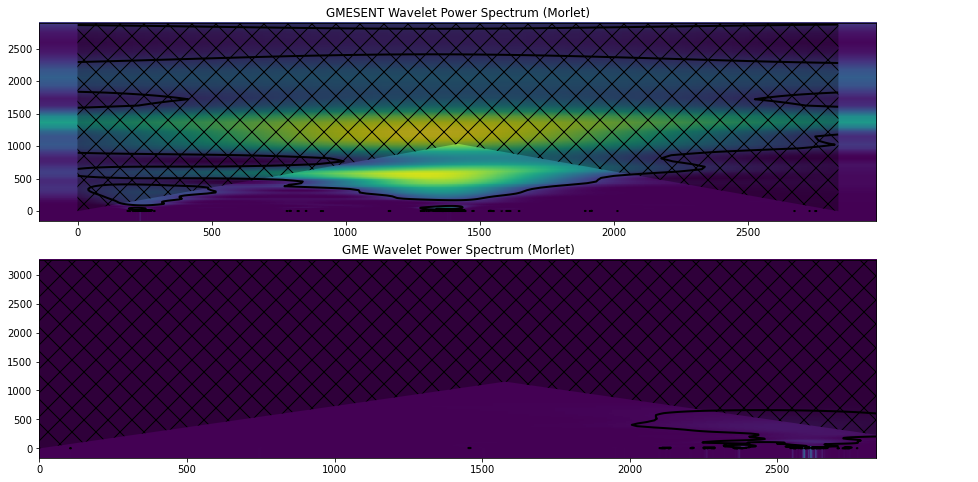

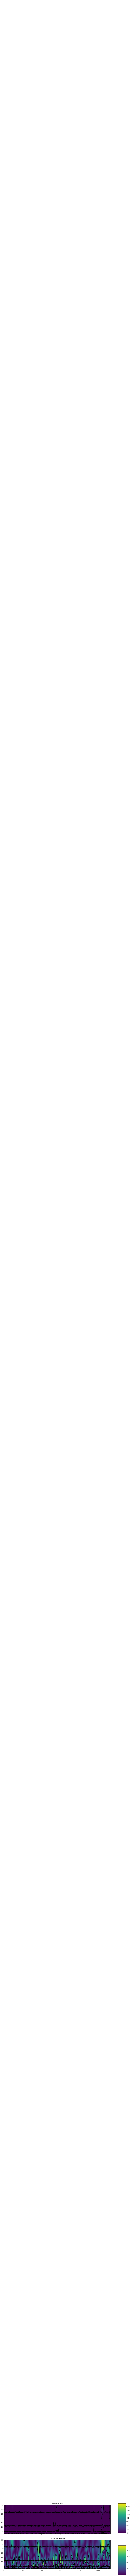

In [160]:
data1 = dict(name='GameStop Sentimet', nick='GME Sent')
data2 = dict(name='GameStop', nick='GME')
mother = 'morlet'

# s1 = np.array(sentiment_lexadj.resample("30min").agg("sum").compound.dropna())
# s1 = np.array(sampled_sent_lexadj.compound.dropna())
s1 = np.array(sampled_sent_lexadj.compound.dropna())
s2 = np.array(gme_standardised.dropna())
timestamps1 = [i.timestamp() for i in sampled_sent_lexadj.compound.dropna().index]
timestamps2 = [i.timestamp() for i in gme_standardised.dropna().index]
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)
# t1 = np.array(timestamps1)
# t2 = np.array(timestamps2)
dt = np.diff(t1)[0]
n1 = t1.size
n2 = t2.size
n = min(n1,n2)

std1 = s1.std()
std2 = s2.std()

mother = wavelet.Morlet(6)
slevel = .95
dj = 1/12
s0 = -1
J = -1

if True:
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    alppha1 = alpha2 = 0.0
    
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)

W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2,
                                           significance_level=slevel,
                                           wavelet=mother)
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1 / sig95_1  
sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2 / sig95_2  

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, figsize = (15,8))

extent1 = [t1.min(),t1.max(), 0, max(period1)]
extent2 = [t2.min(),t2.max(), 0, max(period2)]

im1 = NonUniformImage(ax1, interpolation = "bilinear", extent = extent1)
im1.set_data(t1, period1, power1)
ax1.images.append(im1)
ax1.contour(t1, period1, sig95_1, [-99, 1], colors="k", linewidths=2,
            extent=extent1)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([coi1, [1e-9], period1[-1:], period1[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('{} Wavelet Power Spectrum ({})'.format("GMESENT",
                                                      mother.name))

im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent2)
im2.set_data(t2, period2, power2)
ax2.images.append(im2)
ax2.contour(t2, period2, sig95_2, [-99, 1], colors='k', linewidths=2,
            extent=extent2)
ax2.fill(np.concatenate([t2, t2[-1:]+dt, t2[-1:]+dt, t2[:1]-dt, t2[:1]-dt]),
         np.concatenate([coi2, [1e-9], period2[-1:], period2[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
ax2.set_title('{} Wavelet Power Spectrum ({})'.format(data2['nick'],
                                                      mother.name))

#  II. Cross-wavelet transform
# ===========================

# Due to the difference in the time series, the second signal has to be
# trimmed for the XWT process.
s2 = s2[np.argwhere((t2 >= min(t1)) & (t2 <= max(t1))).flatten()]

# Calculate the cross wavelet transform (XWT). The XWT finds regions in time
# frequency space where the time series show high common power. Torrence and
# Compo (1998) state that the percent point function -- PPF (inverse of the
# cumulative distribution function) -- of a chi-square distribution at 95%
# confidence and two degrees of freedom is Z2(95%)=3.999. However, calculating
# the PPF using chi2.ppf gives Z2(95%)=5.991. To ensure similar significance
# intervals as in Grinsted et al. (2004), one has to use confidence of 86.46%.
W12, cross_coi, freq, signif = wavelet.xwt(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                           significance_level=0.8646,
                                           wavelet='morlet', normalize=True)

cross_power = np.abs(W12)**2
cross_sig = np.ones([1, n]) * signif[:, None]
cross_sig = cross_power / cross_sig  # Power is significant where ratio > 1
cross_period = 1/freq

# Calculate the wavelet coherence (WTC). The WTC finds regions in time
# frequency space where the two time seris co-vary, but do not necessarily have
# high power.
WCT, aWCT, corr_coi, freq, sig = wavelet.wct(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                             significance_level=0.8646,
                                             wavelet='morlet', normalize=True,
                                             cache=True)

cor_sig = np.ones([1, n]) * sig[:, None]
cor_sig = np.abs(WCT) / cor_sig  # Power is significant where ratio > 1
cor_period = 1 / freq

# Calculates the phase between both time series. The phase arrows in the
# cross wavelet power spectrum rotate clockwise with 'north' origin.
# The relative phase relationship convention is the same as adopted
# by Torrence and Webster (1999), where in phase signals point
# upwards (N), anti-phase signals point downwards (S). If X leads Y,
# arrows point to the right (E) and if X lags Y, arrow points to the
# left (W).
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)
qfil = 15

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize = (15,8))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.55, 0.05, 0.35])
cbar_ax_1 = fig.add_axes([0.85, 0.05, 0.05, 0.35])

extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]
im1 = NonUniformImage(ax1, interpolation='bilinear', extent=extent_cross)
im1.set_data(t1, cross_period, cross_power)
ax1.images.append(im1)
ax1.contour(t1, cross_period, cross_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_cross)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([cross_coi, [1e-9], cross_period[-1:],
                         cross_period[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('Cross-Wavelet')
ax1.quiver(t1[::qfil], cross_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil],
           units='width', angles='uv', pivot='mid', linewidth=1,
           edgecolor='k', headwidth=10, headlength=10, headaxislength=5,
           minshaft=2, minlength=5)
fig.colorbar(im1, cax=cbar_ax)

im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent_corr)
im2.set_data(t1, cor_period, WCT)
ax2.images.append(im2)
ax2.contour(t1, cor_period, cor_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_corr)
ax2.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([corr_coi, [1e-9], cor_period[-1:], cor_period[-1:],
                         [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_title('Cross-Correlation')
ax2.quiver(t1[::qfil], cor_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil], units='height',
           angles='uv', pivot='mid', linewidth=1, edgecolor='k',
           headwidth=10, headlength=10, headaxislength=5, minshaft=2,
           minlength=5)
ax2.set_ylim(2, 35)
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
fig.colorbar(im2, cax=cbar_ax_1)

plt.draw()
plt.show()

# GME AMC Waves

NOTE: WCT significance loaded from cache.



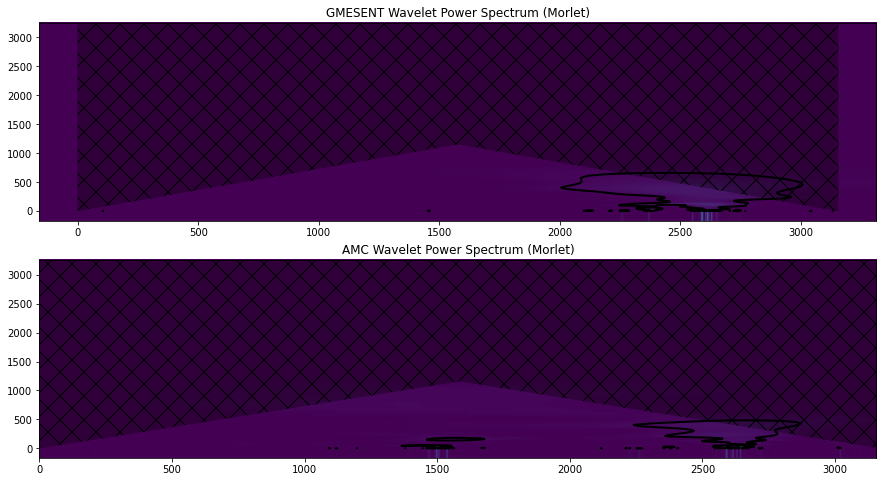

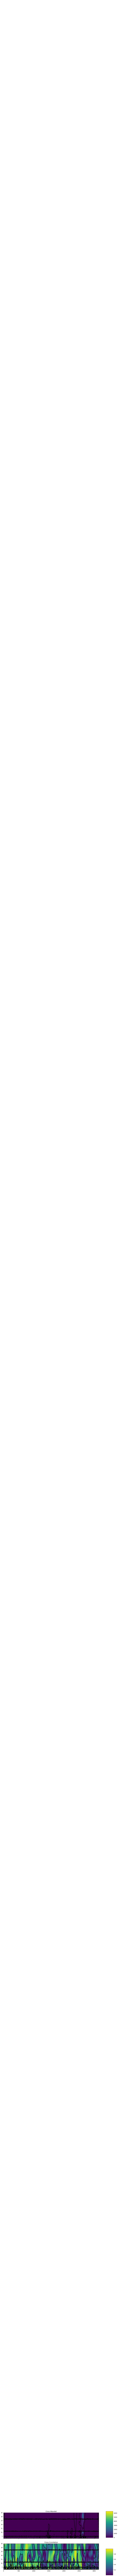

In [159]:
data1 = dict(name='GameStop', nick='GME')
data2 = dict(name='AMC', nick='AMC')
mother = 'morlet'

# s1 = np.array(sentiment_lexadj.resample("30min").agg("sum").compound.dropna())
# s1 = np.array(sampled_sent_lexadj.compound.dropna())
s1 = np.array(gme_standardised.dropna())
s2 = np.array(amc_standardised.dropna())
timestamps1 = [i.timestamp() for i in sampled_sent_lexadj.compound.dropna().index]
timestamps2 = [i.timestamp() for i in amc_standardised.dropna().index]
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)
# t1 = np.array(timestamps1)
# t2 = np.array(timestamps2)
dt = np.diff(t1)[0]
n1 = t1.size
n2 = t2.size
n = min(n1,n2)

std1 = s1.std()
std2 = s2.std()

mother = wavelet.Morlet(6)
slevel = .95
dj = 1/12
s0 = -1
J = -1

if True:
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    alppha1 = alpha2 = 0.0
    
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)

W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2,
                                           significance_level=slevel,
                                           wavelet=mother)
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1 / sig95_1  
sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2 / sig95_2  

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, figsize = (15,8))

extent1 = [t1.min(),t1.max(), 0, max(period1)]
extent2 = [t2.min(),t2.max(), 0, max(period2)]

im1 = NonUniformImage(ax1, interpolation = "bilinear", extent = extent1)
im1.set_data(t1, period1, power1)
ax1.images.append(im1)
ax1.contour(t1, period1, sig95_1, [-99, 1], colors="k", linewidths=2,
            extent=extent1)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([coi1, [1e-9], period1[-1:], period1[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('{} Wavelet Power Spectrum ({})'.format("GMESENT",
                                                      mother.name))

im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent2)
im2.set_data(t2, period2, power2)
ax2.images.append(im2)
ax2.contour(t2, period2, sig95_2, [-99, 1], colors='k', linewidths=2,
            extent=extent2)
ax2.fill(np.concatenate([t2, t2[-1:]+dt, t2[-1:]+dt, t2[:1]-dt, t2[:1]-dt]),
         np.concatenate([coi2, [1e-9], period2[-1:], period2[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
ax2.set_title('{} Wavelet Power Spectrum ({})'.format(data2['nick'],
                                                      mother.name))

#  II. Cross-wavelet transform
# ===========================

# Due to the difference in the time series, the second signal has to be
# trimmed for the XWT process.
s2 = s2[np.argwhere((t2 >= min(t1)) & (t2 <= max(t1))).flatten()]

# Calculate the cross wavelet transform (XWT). The XWT finds regions in time
# frequency space where the time series show high common power. Torrence and
# Compo (1998) state that the percent point function -- PPF (inverse of the
# cumulative distribution function) -- of a chi-square distribution at 95%
# confidence and two degrees of freedom is Z2(95%)=3.999. However, calculating
# the PPF using chi2.ppf gives Z2(95%)=5.991. To ensure similar significance
# intervals as in Grinsted et al. (2004), one has to use confidence of 86.46%.
W12, cross_coi, freq, signif = wavelet.xwt(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                           significance_level=0.8646,
                                           wavelet='morlet', normalize=True)

cross_power = np.abs(W12)**2
cross_sig = np.ones([1, n]) * signif[:, None]
cross_sig = cross_power / cross_sig  # Power is significant where ratio > 1
cross_period = 1/freq

# Calculate the wavelet coherence (WTC). The WTC finds regions in time
# frequency space where the two time seris co-vary, but do not necessarily have
# high power.
WCT, aWCT, corr_coi, freq, sig = wavelet.wct(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                             significance_level=0.8646,
                                             wavelet='morlet', normalize=True,
                                             cache=True)

cor_sig = np.ones([1, n]) * sig[:, None]
cor_sig = np.abs(WCT) / cor_sig  # Power is significant where ratio > 1
cor_period = 1 / freq

# Calculates the phase between both time series. The phase arrows in the
# cross wavelet power spectrum rotate clockwise with 'north' origin.
# The relative phase relationship convention is the same as adopted
# by Torrence and Webster (1999), where in phase signals point
# upwards (N), anti-phase signals point downwards (S). If X leads Y,
# arrows point to the right (E) and if X lags Y, arrow points to the
# left (W).
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)
qfil = 15

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize = (15,8))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.55, 0.05, 0.35])
cbar_ax_1 = fig.add_axes([0.85, 0.05, 0.05, 0.35])

extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]
im1 = NonUniformImage(ax1, interpolation='bilinear', extent=extent_cross)
im1.set_data(t1, cross_period, cross_power)
ax1.images.append(im1)
ax1.contour(t1, cross_period, cross_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_cross)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([cross_coi, [1e-9], cross_period[-1:],
                         cross_period[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('Cross-Wavelet')
ax1.quiver(t1[::qfil], cross_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil],
           units='width', angles='uv', pivot='mid', linewidth=1,
           edgecolor='k', headwidth=10, headlength=10, headaxislength=5,
           minshaft=2, minlength=5)
fig.colorbar(im1, cax=cbar_ax)

im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent_corr)
im2.set_data(t1, cor_period, WCT)
ax2.images.append(im2)
ax2.contour(t1, cor_period, cor_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_corr)
ax2.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([corr_coi, [1e-9], cor_period[-1:], cor_period[-1:],
                         [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_title('Cross-Correlation')
ax2.quiver(t1[::qfil], cor_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil], units='height',
           angles='uv', pivot='mid', linewidth=1, edgecolor='k',
           headwidth=10, headlength=10, headaxislength=5, minshaft=2,
           minlength=5)
ax2.set_ylim(2, 35)
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
fig.colorbar(im2, cax=cbar_ax_1)

plt.draw()
plt.show()

# GME BB WAVES

NOTE: WCT significance loaded from cache.



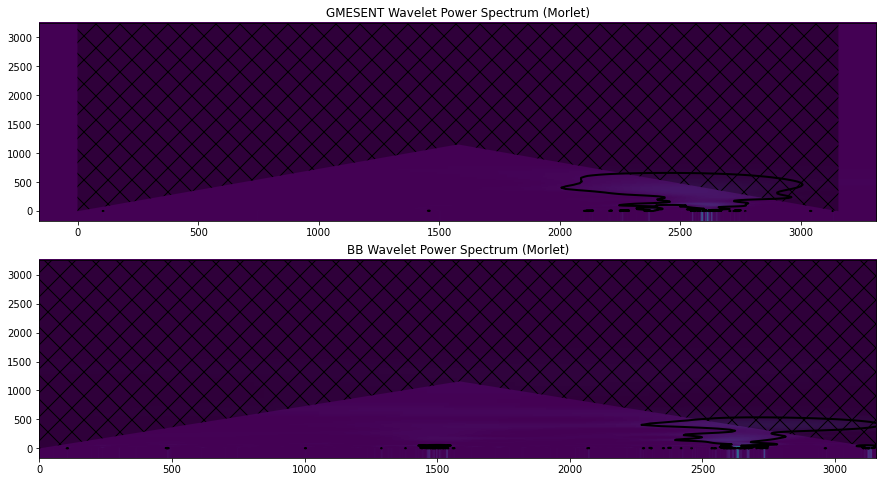

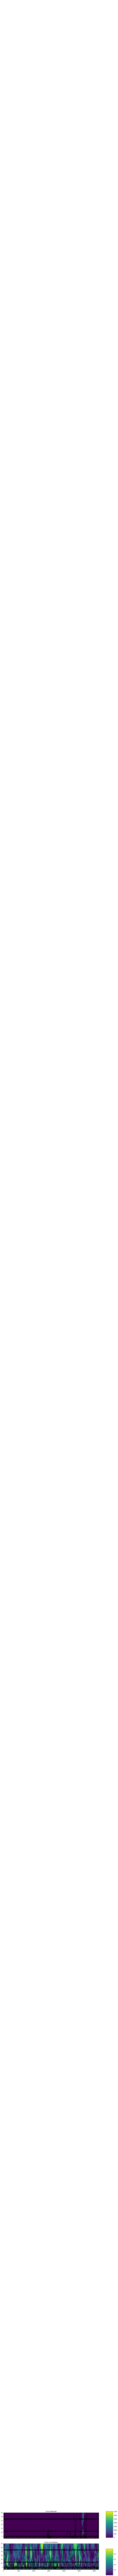

In [158]:
data1 = dict(name='GameStop', nick='GME')
data2 = dict(name='Blackberry', nick='BB')
mother = 'morlet'

# s1 = np.array(sentiment_lexadj.resample("30min").agg("sum").compound.dropna())
# s1 = np.array(sampled_sent_lexadj.compound.dropna())
s1 = np.array(gme_standardised.dropna())
s2 = np.array(bb_standardised.dropna())
timestamps1 = [i.timestamp() for i in gme_standardised.dropna().index]
timestamps2 = [i.timestamp() for i in bb_standardised.dropna().index]
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)
# t1 = np.array(timestamps1)
# t2 = np.array(timestamps2)
dt = np.diff(t1)[0]
n1 = t1.size
n2 = t2.size
n = min(n1,n2)

std1 = s1.std()
std2 = s2.std()

mother = wavelet.Morlet(6)
slevel = .95
dj = 1/12
s0 = -1
J = -1

if True:
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    alppha1 = alpha2 = 0.0
    
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)

W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2,
                                           significance_level=slevel,
                                           wavelet=mother)
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1 / sig95_1  
sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2 / sig95_2  

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, figsize = (15,8))

extent1 = [t1.min(),t1.max(), 0, max(period1)]
extent2 = [t2.min(),t2.max(), 0, max(period2)]

im1 = NonUniformImage(ax1, interpolation = "bilinear", extent = extent1)
im1.set_data(t1, period1, power1)
ax1.images.append(im1)
ax1.contour(t1, period1, sig95_1, [-99, 1], colors="k", linewidths=2,
            extent=extent1)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([coi1, [1e-9], period1[-1:], period1[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('{} Wavelet Power Spectrum ({})'.format("GMESENT",
                                                      mother.name))

im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent2)
im2.set_data(t2, period2, power2)
ax2.images.append(im2)
ax2.contour(t2, period2, sig95_2, [-99, 1], colors='k', linewidths=2,
            extent=extent2)
ax2.fill(np.concatenate([t2, t2[-1:]+dt, t2[-1:]+dt, t2[:1]-dt, t2[:1]-dt]),
         np.concatenate([coi2, [1e-9], period2[-1:], period2[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
ax2.set_title('{} Wavelet Power Spectrum ({})'.format(data2['nick'],
                                                      mother.name))

#  II. Cross-wavelet transform
# ===========================

# Due to the difference in the time series, the second signal has to be
# trimmed for the XWT process.
s2 = s2[np.argwhere((t2 >= min(t1)) & (t2 <= max(t1))).flatten()]

# Calculate the cross wavelet transform (XWT). The XWT finds regions in time
# frequency space where the time series show high common power. Torrence and
# Compo (1998) state that the percent point function -- PPF (inverse of the
# cumulative distribution function) -- of a chi-square distribution at 95%
# confidence and two degrees of freedom is Z2(95%)=3.999. However, calculating
# the PPF using chi2.ppf gives Z2(95%)=5.991. To ensure similar significance
# intervals as in Grinsted et al. (2004), one has to use confidence of 86.46%.
W12, cross_coi, freq, signif = wavelet.xwt(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                           significance_level=0.8646,
                                           wavelet='morlet', normalize=True)

cross_power = np.abs(W12)**2
cross_sig = np.ones([1, n]) * signif[:, None]
cross_sig = cross_power / cross_sig  # Power is significant where ratio > 1
cross_period = 1/freq

# Calculate the wavelet coherence (WTC). The WTC finds regions in time
# frequency space where the two time seris co-vary, but do not necessarily have
# high power.
WCT, aWCT, corr_coi, freq, sig = wavelet.wct(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                             significance_level=0.8646,
                                             wavelet='morlet', normalize=True,
                                             cache=True)

cor_sig = np.ones([1, n]) * sig[:, None]
cor_sig = np.abs(WCT) / cor_sig  # Power is significant where ratio > 1
cor_period = 1 / freq

# Calculates the phase between both time series. The phase arrows in the
# cross wavelet power spectrum rotate clockwise with 'north' origin.
# The relative phase relationship convention is the same as adopted
# by Torrence and Webster (1999), where in phase signals point
# upwards (N), anti-phase signals point downwards (S). If X leads Y,
# arrows point to the right (E) and if X lags Y, arrow points to the
# left (W).
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)
qfil = 15

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize = (15,8))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.55, 0.05, 0.35])
cbar_ax_1 = fig.add_axes([0.85, 0.05, 0.05, 0.35])

extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]
im1 = NonUniformImage(ax1, interpolation='bilinear', extent=extent_cross)
im1.set_data(t1, cross_period, cross_power)
ax1.images.append(im1)
ax1.contour(t1, cross_period, cross_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_cross)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([cross_coi, [1e-9], cross_period[-1:],
                         cross_period[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('Cross-Wavelet')
ax1.quiver(t1[::qfil], cross_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil],
           units='width', angles='uv', pivot='mid', linewidth=1,
           edgecolor='k', headwidth=10, headlength=10, headaxislength=5,
           minshaft=2, minlength=5)
fig.colorbar(im1, cax=cbar_ax)

im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent_corr)
im2.set_data(t1, cor_period, WCT)
ax2.images.append(im2)
ax2.contour(t1, cor_period, cor_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_corr)
ax2.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([corr_coi, [1e-9], cor_period[-1:], cor_period[-1:],
                         [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_title('Cross-Correlation')
ax2.quiver(t1[::qfil], cor_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil], units='height',
           angles='uv', pivot='mid', linewidth=1, edgecolor='k',
           headwidth=10, headlength=10, headaxislength=5, minshaft=2,
           minlength=5)
ax2.set_ylim(2, 35)
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
fig.colorbar(im2, cax=cbar_ax_1)

plt.draw()
plt.show()

# GME CLOV Waves

NOTE: WCT significance loaded from cache.



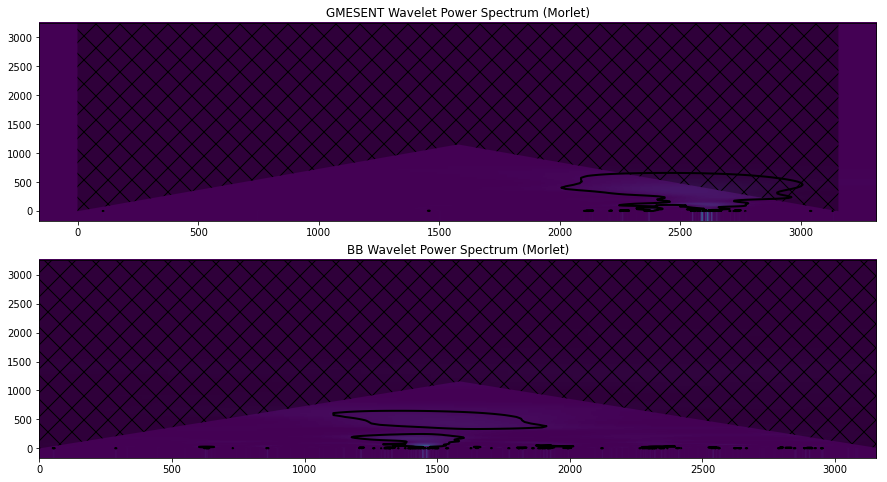

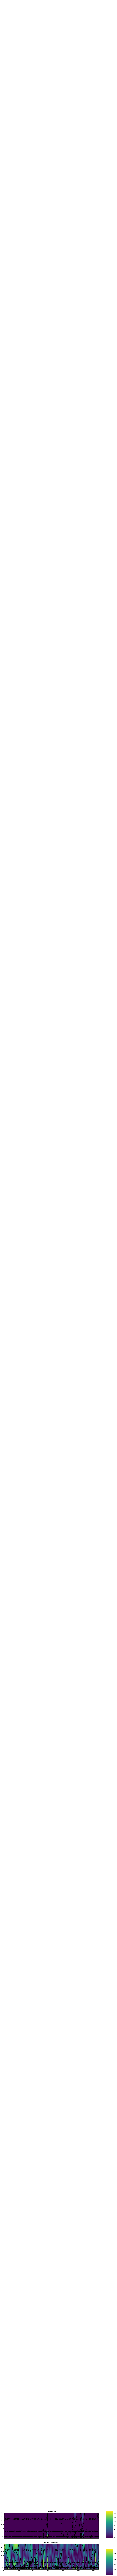

In [157]:
data1 = dict(name='GameStop', nick='GME')
data2 = dict(name='Blackberry', nick='BB')
mother = 'morlet'

# s1 = np.array(sentiment_lexadj.resample("30min").agg("sum").compound.dropna())
# s1 = np.array(sampled_sent_lexadj.compound.dropna())
s1 = np.array(gme_standardised.dropna())
s2 = np.array(clov_standardised.dropna())
timestamps1 = [i.timestamp() for i in gme_standardised.dropna().index]
timestamps2 = [i.timestamp() for i in clov_standardised.dropna().index]
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)
# t1 = np.array(timestamps1)
# t2 = np.array(timestamps2)
dt = np.diff(t1)[0]
n1 = t1.size
n2 = t2.size
n = min(n1,n2)

std1 = s1.std()
std2 = s2.std()

mother = wavelet.Morlet(6)
slevel = .95
dj = 1/12
s0 = -1
J = -1

if True:
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    alppha1 = alpha2 = 0.0
    
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)

W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2,
                                           significance_level=slevel,
                                           wavelet=mother)
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1 / sig95_1  
sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2 / sig95_2  

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, figsize = (15,8))

extent1 = [t1.min(),t1.max(), 0, max(period1)]
extent2 = [t2.min(),t2.max(), 0, max(period2)]

im1 = NonUniformImage(ax1, interpolation = "bilinear", extent = extent1)
im1.set_data(t1, period1, power1)
ax1.images.append(im1)
ax1.contour(t1, period1, sig95_1, [-99, 1], colors="k", linewidths=2,
            extent=extent1)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([coi1, [1e-9], period1[-1:], period1[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('{} Wavelet Power Spectrum ({})'.format("GMESENT",
                                                      mother.name))

im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent2)
im2.set_data(t2, period2, power2)
ax2.images.append(im2)
ax2.contour(t2, period2, sig95_2, [-99, 1], colors='k', linewidths=2,
            extent=extent2)
ax2.fill(np.concatenate([t2, t2[-1:]+dt, t2[-1:]+dt, t2[:1]-dt, t2[:1]-dt]),
         np.concatenate([coi2, [1e-9], period2[-1:], period2[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
ax2.set_title('{} Wavelet Power Spectrum ({})'.format(data2['nick'],
                                                      mother.name))

#  II. Cross-wavelet transform
# ===========================

# Due to the difference in the time series, the second signal has to be
# trimmed for the XWT process.
s2 = s2[np.argwhere((t2 >= min(t1)) & (t2 <= max(t1))).flatten()]

# Calculate the cross wavelet transform (XWT). The XWT finds regions in time
# frequency space where the time series show high common power. Torrence and
# Compo (1998) state that the percent point function -- PPF (inverse of the
# cumulative distribution function) -- of a chi-square distribution at 95%
# confidence and two degrees of freedom is Z2(95%)=3.999. However, calculating
# the PPF using chi2.ppf gives Z2(95%)=5.991. To ensure similar significance
# intervals as in Grinsted et al. (2004), one has to use confidence of 86.46%.
W12, cross_coi, freq, signif = wavelet.xwt(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                           significance_level=0.8646,
                                           wavelet='morlet', normalize=True)

cross_power = np.abs(W12)**2
cross_sig = np.ones([1, n]) * signif[:, None]
cross_sig = cross_power / cross_sig  # Power is significant where ratio > 1
cross_period = 1/freq

# Calculate the wavelet coherence (WTC). The WTC finds regions in time
# frequency space where the two time seris co-vary, but do not necessarily have
# high power.
WCT, aWCT, corr_coi, freq, sig = wavelet.wct(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                             significance_level=0.8646,
                                             wavelet='morlet', normalize=True,
                                             cache=True)

cor_sig = np.ones([1, n]) * sig[:, None]
cor_sig = np.abs(WCT) / cor_sig  # Power is significant where ratio > 1
cor_period = 1 / freq

# Calculates the phase between both time series. The phase arrows in the
# cross wavelet power spectrum rotate clockwise with 'north' origin.
# The relative phase relationship convention is the same as adopted
# by Torrence and Webster (1999), where in phase signals point
# upwards (N), anti-phase signals point downwards (S). If X leads Y,
# arrows point to the right (E) and if X lags Y, arrow points to the
# left (W).
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)
qfil = 15

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize = (15,8))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.55, 0.05, 0.35])
cbar_ax_1 = fig.add_axes([0.85, 0.05, 0.05, 0.35])

extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]
im1 = NonUniformImage(ax1, interpolation='bilinear', extent=extent_cross)
im1.set_data(t1, cross_period, cross_power)
ax1.images.append(im1)
ax1.contour(t1, cross_period, cross_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_cross)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([cross_coi, [1e-9], cross_period[-1:],
                         cross_period[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('Cross-Wavelet')
ax1.quiver(t1[::qfil], cross_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil],
           units='width', angles='uv', pivot='mid', linewidth=1,
           edgecolor='k', headwidth=10, headlength=10, headaxislength=5,
           minshaft=2, minlength=5)
fig.colorbar(im1, cax=cbar_ax)

im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent_corr)
im2.set_data(t1, cor_period, WCT)
ax2.images.append(im2)
ax2.contour(t1, cor_period, cor_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_corr)
ax2.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([corr_coi, [1e-9], cor_period[-1:], cor_period[-1:],
                         [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_title('Cross-Correlation')
ax2.quiver(t1[::qfil], cor_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil], units='height',
           angles='uv', pivot='mid', linewidth=1, edgecolor='k',
           headwidth=10, headlength=10, headaxislength=5, minshaft=2,
           minlength=5)
ax2.set_ylim(2, 35)
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
fig.colorbar(im2, cax=cbar_ax_1)

plt.draw()
plt.show()